# Generative Image Inpainting with Contextual Attention

![Screen%20Shot%202019-03-29%20at%209.38.35%20AM.png](img/Screen%20Shot%202019-03-29%20at%209.38.35%20AM.png)

Image inpainting is an important task in computer vision. The task of image inpainting or completion is to fill in the missing pixels of corrupted images. It has many applications in photo editing, image-based rendering and computational photography. The core challenge lies in synthesizing visually realistic and semantically plausible pixels for the missing regions that are coherent with exisiting ones. In the above figure are different examples for inpainting results. Left is the input image with the white regions which are missing and should be completed. On the right are the output images of the trained network from the original paper: https://arxiv.org/abs/1801.07892

In [5]:
from config import *
from model_helper import *
from dataloader import *
from helper import *

## Generative Adversarial Networks

Generative Adversarial Networks takes up a game-theoretic approach, unlike a conventional neural network. The network learns to generate from a training distribution through a 2-player game. The two entities are Generator and Discriminator. These two adversaries are in constant battle throughout the training process. Since an adversarial learning method is adopted, we need not care about approximating intractable density functions.

![image.png](img/gan.png)

As you can identify from their names, a generator is used to generate real-looking images and the discriminator’s job is to identify which one is a fake. The entities/adversaries are in constant battle as one(generator) tries to fool the other(discriminator), while the other tries not to be fooled. To generate the best images you will need a very good generator and a discriminator. This is because if your generator is not good enough, it will never be able to fool the discriminator and the model will never converge. If the discriminator is bad, then images which make no sense will also be classified as real and hence your model never trains and in turn you never produces the desired output. The input, random noise can be a Gaussian distribution and values can be sampled from this distribution and fed into the generator network and an image is generated. This generated image is compared with a real image by the discriminator and it tries to identify if the given image is fake or real.

Reference: https://towardsdatascience.com/generative-adversarial-networks-explained-34472718707a

### Wasserstein Distance

Wasserstein Distance is a measure of the distance between two probability distributions. It is also called Earth Mover’s distance, short for EM distance, because informally it can be interpreted as the minimum energy cost of moving and transforming a pile of dirt in the shape of one probability distribution to the shape of the other distribution. The cost is quantified by: the amount of dirt moved x the moving distance.

### Wasserstein GANs

Difference to normal GANs:
 - After every gradient update on the critic function, clamp the weights to a small fixed range, [−c,c] (for K-Lipschitz coutinuous https://en.wikipedia.org/wiki/Lipschitz_continuity ).
     - A differentiable function f is 1-Lipschtiz if and only if it has gradients with norm at most 1 everywhere.
 - Use a new loss function derived from the Wasserstein distance, no logarithm anymore. The “discriminator” model does not play as a direct critic but a helper for estimating the Wasserstein metric between real and generated data distribution.
 
Reference: https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html#wasserstein-gan-wgan

![loss.png](img/loss.png)

### Gradient Penalty for WGANs

* instead of applying clipping, WGAN-GP penalizes the model if the gradient norm moves away from its target norm value 1.
 
     => better image quality and convergence comparing with WGAN and also easier to train
     
Reference: https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490

## Dilated Convolutions

A recent development (e.g. see paper by Fisher Yu and Vladlen Koltun) is to introduce one more hyperparameter to the CONV layer called the dilation. So far we’ve only discussed CONV filters that are contiguous. However, it’s possible to have filters that have spaces between each cell, called dilation. As an example, in one dimension a filter w of size 3 would compute over input x the following: `w[0]*x[0] + w[1]*x[1] + w[2]*x[2]`. This is dilation of 0. For dilation 1 the filter would instead compute `w[0]*x[0] + w[1]*x[2] + w[2]*x[4]`; In other words there is a gap of 1 between the applications. This can be very useful in some settings to use in conjunction with 0-dilated filters because it allows you to merge spatial information across the inputs much more agressively with fewer layers. For example, if you stack two 3x3 CONV layers on top of each other then you can convince yourself that the neurons on the 2nd layer are a function of a 5x5 patch of the input (we would say that the effective receptive field of these neurons is 5x5). If we use dilated convolutions then this effective receptive field would grow much quicker.

![Screen%20Shot%202019-03-29%20at%204.35.42%20PM.png](img/Screen%20Shot%202019-03-29%20at%204.35.42%20PM.png)

Reference: https://arxiv.org/abs/1511.07122 and https://towardsdatascience.com/understanding-2d-dilated-convolution-operation-with-examples-in-numpy-and-tensorflow-with-d376b3972b25

## Upsampling

<img src="img/Screen%20Shot%202019-04-03%20at%209.12.19%20AM.png" alt="Drawing" style="width: 300px;"/>

 * Nearest-Neighbor: Copies the value from the nearest pixel.
 * Bilinear: Uses all nearby pixels to calculate the pixel's value, using linear interpolations.
 * Bicubic: Again uses all nearby pixels to calculate the pixel's values, through polynomial interpolations. Usually produces a smoother surface than the previous techniques, but its harder to compute.

 
## Transposed Convolution

 * A convolution operation forms a many-to-one relationship.
 * Tranposed Convolution forms a one-to-many relationship. This is like going backward of convolution operation, and it is the core idea of transposed convolution.
 
### Normal Convolution Operation

![Screen%20Shot%202019-04-03%20at%2010.00.14%20AM.png](img/Screen%20Shot%202019-04-03%20at%2010.00.14%20AM.png)

### Normal Convolution with Multiplication

![Screen%20Shot%202019-04-03%20at%2010.01.44%20AM.png](img/Screen%20Shot%202019-04-03%20at%2010.01.44%20AM.png)

### Transposed Convolution

<img src="img/Screen%20Shot%202019-04-03%20at%2010.04.23%20AM.png" alt="Drawing" style="width: 500px;"/>

The output can be reshaped into 4x4:

<img src="img/Screen%20Shot%202019-04-03%20at%2010.06.39%20AM.png" alt="Drawing" style="width: 300px;"/>

 
Reference: https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0 and https://arxiv.org/abs/1603.07285

# Network Architecture

![Screen%20Shot%202019-03-29%20at%204.44.17%20PM.png](img/Screen%20Shot%202019-03-29%20at%204.44.17%20PM.png)

Overview of the improved generative inpainting framework. The coarse network is trained with reconstruction loss explicitly, while the refinement network is trained with reconstruction loss, global and local WGAN-GP adversarial loss.

## Coarse-to-fine network architecture

### Input
The generator network takes an image with white pixels filled in the holes and a binary mask indicating the hole regions as input pairs, and outputs the final completed image. The input to the network is a $128x128$ image with a rectangle missing region sampled randomly during training.

![input-image.png](img/input-image.png)

![input-image2.png](img/input-image2.png)

### Two-stage network
The first network makes an intial coarse prediction, and the second network takes the coarse predictions inputs and predict refined results. The coarse network is trained with the reconstruction loss explicitily, while the refinement network is trained with the reconstruction as well as GAN losses. The refinement network sees a more complete scene than the original image with missing regions, so its encoder can learn better feature representation than the coarse network.

## Spatially discounted reconstruction loss
Inpainting problems involve hallucination of pixels, so it could have many plausible solutions for any given context. In challenging cases, a plausible completed image can have patches or pixels that are very different from those in the original image. As we use the original image as the only ground truth to compute a reconstruction loss, strong enforcement of reconstruction loss in those pixels may mislead the training process of convolutional network.

Intuitively, missing pixels near the hole boundaries have much less ambiguity than those pixels closer to the center of the hole. This is similar to the issue observed in reinforcement learning. When long-term rewards have large variations during sampling, people use temporal discounted rewards over sampled trajectories. Inspired by this, the team introduced a spatially discounted reconstruction loss using a weight mask $M$. The weight of each pixel in the mask is computed as $\gamma^l$, where $l$ is the distance of the pixel to the nearest known pixel. $\gamma$ is set to $0.99$ in all experiments.

For inpainting large hole, the proposed discounted loss is more effective for improving the visual quality. The paper uses discounted l1 reconstruction loss in their implementation.

# Image Inpainting with Contextual Attention
Convolutional neural networks process image features with local convolutional kernel layer by layer thus are not effective for borrowing features from distant spatial locations. To overcome the limitation, we consider attention mechanism and introduce a novel contextual attention layer in the deep generative network.

## Contextual Attention

![Screen%20Shot%202019-03-29%20at%204.46.19%20PM.png](img/Screen%20Shot%202019-03-29%20at%204.46.19%20PM.png)

The contextual attention layer learns where to borrow or copy feature information from known background patches to generate missing patches. It is differentiable, thus can be trained in deep models, and fully-convolutional, which allows testing on arbitrary resolutions.

### Match and attend
We consider the problem where we want to match features of missing pixels (foreground) to surroundings (background). As shown in the figure above, we first extract patches $(3 × 3)$ in background and reshape them as convolutional filters. To match foreground patches ${f_{x,y}}$ with backgrounds ones ${b_{x′ ,y′}}$, we measure with normalized inner product (cosine similarity).

<img src="img/Screen%20Shot%202019-03-31%20at%2012.58.12%20PM.png" alt="Drawing" style="width: 300px;"/>

where $s_{x,y,x′,y′}$ represents similarity of patch centered in background $(x′, y′)$ and foreground $(x, y)$. Then we weigh the similarity with scaled softmax along $x′y′$-dimension to get attention score for each pixel $s^∗_{x,y,x′,y′} = softmax_{x′,y′}(\lambda s_{x,y,x′,y′})$, where $\lambda$ is a constant value. This is efficiently implemented as convolution and channel-wise softmax. Finally, we reuse extracted patches {$b_{x′,y′}$} as deconvolutional filters to reconstruct foregrounds. Values of overlapped pixels are averaged.


### Attention propagation
The idea of coherency is that a shift in foreground patch is likely corresponding to an equal shift in background patch for attention. For example, $s^∗_{x,y,x′,y′}$ usually have close value with $s^∗_{x+1,y,x′+1,y′}$. To model and encourage coherency of attention maps, we do a left-right propagation followed by a top-down propagation with kernel size of k. Take left-right propagation as an example, we get new attention score with:

<img src="img/Screen%20Shot%202019-03-31%20at%201.05.46%20PM.png" alt="Drawing" style="width: 300px;"/>

The propagation is efficiently implemented as convolution with identity matrix as kernels. Attention propagation significantly improves inpainting results in testing and enriches gradients in training.

# Unified Inpainting Network

![Screen%20Shot%202019-03-29%20at%204.46.24%20PM.png](img/Screen%20Shot%202019-03-29%20at%204.46.24%20PM.png)

Based on coarse result from the first encoder-decoder network, two parallel encoders are introduced and then merged to single decoder to get inpainting result. For visualization of attention map, color indicates relative location of the most interested background patch for each pixel in foreground. For examples, white (center of color coding map) means the pixel attends on itself, pink on bottom-left, green means on top-right.

The bottom encoder specifically focuses on hallucinating contents with layer-by-layer (dilated) convolution, while the top one tries to attend on background features of interest. Output features from two encoders are aggregated and fed into a single decoder to obtain the final output. To interpret contextual attention, we visualize it in a way shown in the above figure. We use color to indicate the relative location of the most interested background patch for each foreground pixel. For examples, white (center of color coding map) means the pixel attends on itself, pink on bottom-left, green on top-right. The offset value is scaled differently for different images to best visualize the most interesting range.

# Algorithm

For training, given a raw image $x$, we sample a binary image mask m at a random location. Input image $z$ is cor- rupted from the raw image as $z = x ⊙ m$. Inpainting network $G$ takes concatenation of $z$ and $m$ as input, and output predicted image $x′ = G(z, m)$ with the same size as input. Pasting the masked region of $x′$ to input image, we get the inpainting output $x ̃ = z + x′ ⊙ (1 − m)$. Image values of input and output are linearly scaled to $[−1, 1]$ in all experiments.

<img src="img/Screen%20Shot%202019-03-30%20at%2010.40.37%20AM.png" alt="Drawing" style="width: 500px;"/>


# Implementation
This chapter explains the code and matches the different parts of the code to the explained theory blocks.

## Generate the random masks

In [ ]:
def random_bbox(self):
    img_shape = self.args.IMG_SHAPE
    img_height = img_shape[0]
    img_width = img_shape[1]

    maxt = img_height - self.args.VERTICAL_MARGIN - self.args.MASK_HEIGHT
    maxl = img_width - self.args.HORIZONTAL_MARGIN - self.args.MASK_WIDTH

    t = randint(self.args.VERTICAL_MARGIN, maxt)
    l = randint(self.args.HORIZONTAL_MARGIN, maxl)
    h = self.args.MASK_HEIGHT
    w = self.args.MASK_WIDTH
    return (t, l, h, w)

def bbox2mask(self, bbox):
    """Generate mask tensor from bbox.
    Args:
        bbox: configuration tuple, (top, left, height, width)
        config: Config should have configuration including IMG_SHAPES,
            MAX_DELTA_HEIGHT, MAX_DELTA_WIDTH.
    Returns:
        tf.Tensor: output with shape [B, 1, H, W]
    """

    def npmask(bbox, height, width, delta_h, delta_w):
        mask = np.zeros((1, 1, height, width), np.float32)
        h = np.random.randint(delta_h // 2 + 1)
        w = np.random.randint(delta_w // 2 + 1)
        mask[:, :, bbox[0] + h: bbox[0] + bbox[2] - h,
        bbox[1] + w: bbox[1] + bbox[3] - w] = 1.
        return mask

    img_shape = self.args.IMG_SHAPE
    height = img_shape[0]
    width = img_shape[1]

    mask = npmask(bbox, height, width,
                  self.args.MAX_DELTA_HEIGHT,
                  self.args.MAX_DELTA_WIDTH)

    return torch.FloatTensor(mask)

## Spatial discounted reconstruction loss

In [ ]:
class Discounted_L1(nn.Module):
    def __init__(self, args, size_average=True, reduce=True):
        super(Discounted_L1, self).__init__()
        self.reduce = reduce
        self.discounting_mask = spatial_discounting_mask(args.MASK_WIDTH,
                                                         args.MASK_HEIGHT,
                                                         args.SPATIAL_DISCOUNTING_GAMMA)
        self.size_average = size_average

    def forward(self, input_val, target):
        self._assert_no_grad(target)
        return self._pointwise_loss(lambda a, b: torch.abs(a - b), torch._C._nn.l1_loss,
                                    input_val, target, self.discounting_mask, self.size_average, self.reduce)

    def _assert_no_grad(self, variable):
        assert not variable.requires_grad, \
            "nn criterions don't compute the gradient w.r.t. targets - please " \
            "mark these variables as volatile or not requiring gradients"

    def _pointwise_loss(self, lambd, lambd_optimized, input_val, target, discounting_mask, size_average=True, reduce=True):
        if target.requires_grad:
            d = lambd(input_val, target)
            d = d * discounting_mask
            if not reduce:
                return d
            return torch.mean(d) if size_average else torch.sum(d)
        else:
            return lambd_optimized(input_val, target, size_average, reduce)


def spatial_discounting_mask(mask_width, mask_height, discounting_gamma):
    """Generate spatial discounting mask constant.
    Spatial discounting mask is first introduced in publication:
        Generative Image Inpainting with Contextual Attention, Yu et al.
    Returns:
        tf.Tensor: spatial discounting mask
    """
    gamma = discounting_gamma
    shape = [1, 1, mask_width, mask_height]
    if True:
        print('Use spatial discounting l1 loss.')
        mask_values = np.ones((mask_width, mask_height))
        for i in range(mask_width):
            for j in range(mask_height):
                mask_values[i, j] = max(
                    gamma ** min(i, mask_width - i),
                    gamma ** min(j, mask_height - j))
        mask_values = np.expand_dims(mask_values, 0)
        mask_values = np.expand_dims(mask_values, 1)
        mask_values = mask_values
    else:
        mask_values = np.ones(shape)
    # it will be extended along the batch dimension suitably
    mask_values = torch.from_numpy(mask_values).float()

    return to_var(mask_values)

## Contextual attention module
The code block below shows the contextual attention module and the forward function.

In [ ]:
class ContextualAttentionModule(nn.Module):
    def __init__(self, in_ch, out_ch, rate=2, stride=1, device='cpu'):
        super(ContextualAttentionModule, self).__init__()
        self.rate = rate
        self.padding = nn.ZeroPad2d(1)
        self.up_sample = nn.Upsample(scale_factor=self.rate, mode='nearest')
        layers = []
        for i in range(2):
            layers.append(gen_conv_module(in_ch, out_ch))

        self.out = nn.Sequential(*layers)
        self.device = device

    def forward(self, f, b, mask=None, ksize=3, stride=1,
                fuse_k=3, softmax_scale=10., training=True, fuse=True):

        """ Contextual attention layer implementation.
        Contextual attention is first introduced in publication:
            Generative Image Inpainting with Contextual Attention, Yu et al.
        Args:
            f: Input feature to match (foreground).
            b: Input feature for match (background).
            mask: Input mask for b, indicating patches not available.
            ksize: Kernel size for contextual attention.
            stride: Stride for extracting patches from b.
            rate: Dilation for matching.
            softmax_scale: Scaled softmax for attention.
            training: Indicating if current graph is training or inference.
        Returns:
            tf.Tensor: output
        """

        # get shapes
        raw_fs = f.size()  # B x 128 x 64 x 64
        raw_int_fs = list(f.size())
        raw_int_bs = list(b.size())

        # extract patches from background with stride and rate
        kernel = 2 * self.rate
        raw_w = self.extract_patches(b, kernel=kernel, stride=self.rate)
        raw_w = raw_w.contiguous().view(raw_int_bs[0], -1, raw_int_bs[1], kernel,
                                        kernel)  # B*HW*C*K*K (B, 32*32, 128, 4, 4)

        # downscaling foreground option: downscaling both foreground and
        # background for matching and use original background for reconstruction.
        f = down_sample(f, scale_factor=1 / self.rate, mode='nearest')
        b = down_sample(b, scale_factor=1 / self.rate, mode='nearest')
        fs = f.size()  # B x 128 x 32 x 32
        int_fs = list(f.size())
        f_groups = torch.split(f, 1, dim=0)  # Split tensors by batch dimension; tuple is returned

        # from b(B*H*W*C) to w(b*k*k*c*h*w)
        bs = b.size()  # B x 128 x 32 x 32
        int_bs = list(b.size())
        w = self.extract_patches(b)

        w = w.contiguous().view(int_fs[0], -1, int_fs[1], ksize, ksize)  # B*HW*C*K*K (B, 32*32, 128, 3, 3)

        # process mask
        if mask is not None:
            mask = down_sample(mask, scale_factor=1. / self.rate, mode='nearest')
        else:
            mask = torch.zeros([1, 1, bs[2], bs[3]])

        m = self.extract_patches(mask)

        m = m.contiguous().view(1, 1, -1, ksize, ksize)  # B*C*HW*K*K
        m = m[0]  # (1, 32*32, 3, 3)
        m = reduce_mean(m)  # smoothing, maybe
        mm = m.eq(0.).float()  # (1, 32*32, 1, 1)

        w_groups = torch.split(w, 1, dim=0)  # Split tensors by batch dimension; tuple is returned
        raw_w_groups = torch.split(raw_w, 1, dim=0)  # Split tensors by batch dimension; tuple is returned
        y = []
        offsets = []
        k = fuse_k
        scale = softmax_scale
        
        # eye creates an identity matrix
        fuse_weight = Variable(torch.eye(k).view(1, 1, k, k)).to(self.device)  # 1 x 1 x K x K

        for xi, wi, raw_wi in zip(f_groups, w_groups, raw_w_groups):
            '''
            O => output channel as a conv filter
            I => input channel as a conv filter
            xi : separated tensor along batch dimension of front; (B=1, C=128, H=32, W=32)
            wi : separated patch tensor along batch dimension of back; (B=1, O=32*32, I=128, KH=3, KW=3)
            raw_wi : separated tensor along batch dimension of back; (B=1, I=32*32, O=128, KH=4, KW=4)
            '''
            # conv for compare
            wi = wi[0]
            escape_NaN = Variable(torch.FloatTensor([1e-4])).to(self.device)
            wi_normed = wi / torch.max(l2_norm(wi), escape_NaN)
            yi = F.conv2d(xi, wi_normed, stride=1, padding=1)  # yi => (B=1, C=32*32, H=32, W=32)
            
            ##########################################
            ### Attention Propagation
            ##########################################
            
            # conv implementation for fuse scores to encourage large patches
            if fuse:
                yi = yi.view(1, 1, fs[2] * fs[3],
                             bs[2] * bs[3])  # make all of depth to spatial resolution, (B=1, I=1, H=32*32, W=32*32)
                yi = F.conv2d(yi, fuse_weight, stride=1, padding=1)  # (B=1, C=1, H=32*32, W=32*32)

                yi = yi.contiguous().view(1, fs[2], fs[3], bs[2], bs[3])  # (B=1, 32, 32, 32, 32)
                yi = yi.permute(0, 2, 1, 4, 3)
                yi = yi.contiguous().view(1, 1, fs[2] * fs[3], bs[2] * bs[3])

                yi = F.conv2d(yi, fuse_weight, stride=1, padding=1)
                yi = yi.contiguous().view(1, fs[3], fs[2], bs[3], bs[2])
                yi = yi.permute(0, 2, 1, 4, 3)
            
            ###########################################
            
            yi = yi.contiguous().view(1, bs[2] * bs[3], fs[2], fs[3])  # (B=1, C=32*32, H=32, W=32)

            # scaled softmax to match
            yi = yi * mm  # mm => (1, 32*32, 1, 1)
            yi = F.softmax(yi * scale, dim=1)
            yi = yi * mm  # mask

            _, offset = torch.max(yi, dim=1)  # argmax; index
            division = torch.div(offset, fs[3]).long()
            offset = torch.stack([division, torch.div(offset, fs[3]) - division], dim=-1)

            # deconv for patch pasting
            # 3.1 paste center
            wi_center = raw_wi[0]
            yi = F.conv_transpose2d(yi, wi_center, stride=self.rate, padding=1) / 4.  # (B=1, C=128, H=64, W=64)
            y.append(yi)
            offsets.append(offset)

        y = torch.cat(y, dim=0)  # back to the mini-batch
        y.contiguous().view(raw_int_fs)
        offsets = torch.cat(offsets, dim=0)
        offsets = offsets.view([int_bs[0]] + [2] + int_bs[2:])

        # case1: visualize optical flow: minus current position
        h_add = Variable(torch.arange(0, float(bs[2]))).to(self.device).view([1, 1, bs[2], 1])
        h_add = h_add.expand(bs[0], 1, bs[2], bs[3])
        w_add = Variable(torch.arange(0, float(bs[3]))).to(self.device).view([1, 1, 1, bs[3]])
        w_add = w_add.expand(bs[0], 1, bs[2], bs[3])

        offsets = offsets - torch.cat([h_add, w_add], dim=1).long()

        # to flow image
        flow = torch.from_numpy(flow_to_image(offsets.permute(0, 2, 3, 1).cpu().data.numpy()))
        flow = flow.permute(0, 3, 1, 2)

        # # case2: visualize which pixels are attended
        # flow = torch.from_numpy(highlight_flow((offsets * mask.int()).numpy()))
        if self.rate != 1:
            flow = self.up_sample(flow)
        return self.out(y), flow

    # padding1(16 x 128 x 64 x 64) => (16 x 128 x 64 x 64 x 3 x 3)
    def extract_patches(self, x, kernel=3, stride=1):
        x = self.padding(x)
        x = x.permute(0, 2, 3, 1)
        all_patches = x.unfold(1, kernel, stride).unfold(2, kernel, stride)
        return all_patches

## Wasserstein GANs
The two code blocks below shows the code for the local and global discriminator and the generator of the WGANs.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, first_dim=64):
        super(Discriminator, self).__init__()
        self.global_discriminator = gen_flatten_module(3, first_dim, False)
        self.local_discriminator = gen_flatten_module(3, first_dim, True)

    def forward(self, global_x, local_x):
        global_y = self.global_discriminator(global_x)
        local_y = self.local_discriminator(local_x)

        return global_y, local_y  # B x 256*(256 or 512)

In [ ]:
class Generator(nn.Module):
    def __init__(self, first_dim=32):
        super(Generator, self).__init__()
        self.stage_1 = CoarseNet(5, first_dim)
        self.stage_2 = RefinementNet(5, first_dim)

    def forward(self, masked_img, mask):  # mask : 1 x 1 x H x W
        # border, maybe
        mask = mask.expand(masked_img.size(0), 1, masked_img.size(2), masked_img.size(3))
        ones = to_var(torch.ones(mask.size()))

        # stage1
        stage1_input = torch.cat([masked_img, ones, ones * mask], dim=1)
        stage1_output, resized_mask = self.stage_1(stage1_input, mask[0].unsqueeze(0))

        # stage2
        new_masked_img = stage1_output * mask + masked_img.clone() * (1. - mask)
        stage2_input = torch.cat([new_masked_img, ones, ones * mask], dim=1)
        stage2_output, offset_flow = self.stage_2(stage2_input, resized_mask[0].unsqueeze(0))

        return stage1_output, stage2_output, offset_flow


class CoarseNet(nn.Module):
    '''
    # input: B x 5 x W x H
    # after down: B x 128(32*4) x W/4 x H/4
    # after atrous: same with the output size of the down module
    # after up : same with the input size
    '''

    def __init__(self, in_ch, out_ch):
        super(CoarseNet, self).__init__()
        self.down = gen_down_module(in_ch, out_ch)
        self.atrous = gen_dilation_module(out_ch * 4, out_ch * 4)
        self.up = gen_up_module(out_ch * 4, 3)

    def forward(self, x, mask):
        x = self.down(x)
        resized_mask = down_sample(mask, scale_factor=0.25, mode='nearest')
        x = self.atrous(x)
        x = torch.clamp(self.up(x), min=-1., max=1.)
        return x, resized_mask


class RefinementNet(nn.Module):
    '''
    # input: B x 5 x W x H
    # after down: B x 128(32*4) x W/4 x H/4
    # after atrous: same with the output size of the down module
    # after up : same with the input size
    '''

    def __init__(self, in_ch, out_ch):
        super(RefinementNet, self).__init__()
        self.down_conv_branch = gen_down_module(in_ch, out_ch)
        self.down_attn_branch = gen_down_module(in_ch, out_ch, activation=nn.ReLU())
        self.atrous = gen_dilation_module(out_ch * 4, out_ch * 4)
        self.CAttn = ContextualAttentionModule(out_ch * 4, out_ch * 4)
        self.up = gen_up_module(out_ch * 8, 3, is_refine=True)

    def forward(self, x, resized_mask):
        # conv branch
        conv_x = self.down_conv_branch(x)
        conv_x = self.atrous(conv_x)

        # attention branch
        attn_x = self.down_attn_branch(x)
        attn_x, offset_flow = self.CAttn(attn_x, attn_x, mask=resized_mask)  # attn_x => B x 128(32*4) x W/4 x H/4

        # concat two branches
        deconv_x = torch.cat([conv_x, attn_x], dim=1)  # deconv_x => B x 256 x W/4 x H/4
        x = torch.clamp(self.up(deconv_x), min=-1., max=1.)

        return x, offset_flow

## The training algorithm
The methods below shows the training algorithm and some helper functions.

In [ ]:
def train(self):

    # The number of iterations per epoch
    iters_per_epoch = len(self.data_loader)

    # lr cache for decaying
    g_lr = self.g_lr
    d_lr = self.d_lr

    if self.pretrained_model:
        start = int(self.pretrained_model.split('_')[0])
    else:
        start = 0

    start_time = time.time()
    self.G.train()
    self.D.train()
    for epoch in range(start, self.num_epochs):
        for batch, real_image in enumerate(self.data_loader):  # real_image : B x 3 x H x W
            batch_size = real_image.size(0)
            real_image = 2. * real_image - 1.  # [-1,1]

            # one bbox for each batch, ( top, left, maxH, maxW )
            # W and H will be reduced at the function bbox2mask
            bbox = self.util.random_bbox()

            binary_mask = self.util.bbox2mask(bbox)
            inverse_mask = 1. - binary_mask
            masked_image = real_image.clone() * inverse_mask

            binary_mask = to_var(binary_mask)
            inverse_mask = to_var(inverse_mask)
            masked_image = to_var(masked_image)
            real_image = to_var(real_image)

            stage_1, stage_2, offset_flow = self.G(masked_image, binary_mask)

            fake_image = stage_2 * binary_mask + masked_image * inverse_mask  # mask_location: generated, around_mask: ground_truth

            real_patch = self.util.local_patch(real_image, bbox)
            stage_1_patch = self.util.local_patch(stage_1, bbox)
            stage_2_patch = self.util.local_patch(stage_2, bbox)
            mask_patch = self.util.local_patch(binary_mask, bbox)
            fake_patch = self.util.local_patch(fake_image, bbox)

            l1_alpha = self.stage1_lambda_l1
            self.loss['recon'] = l1_alpha * self.L1(stage_1_patch, real_patch)  # Coarse Network reconstruction loss
            self.loss['recon'] = self.loss['recon'] + self.L1(stage_2_patch,
                                                              real_patch)  # Refinement Network reconstruction loss

            self.loss['ae_loss'] = l1_alpha * self.torch_L1(stage_1 * inverse_mask,
                                                            real_image * inverse_mask)  # recon loss except mask
            self.loss['ae_loss'] = self.loss['ae_loss'] + self.torch_L1(stage_2 * inverse_mask,
                                                                        real_image * inverse_mask)  # recon loss except mask
            self.loss['ae_loss'] = self.loss['ae_loss'] / torch.mean(torch.mean(inverse_mask, dim=3),
                                                                     dim=2)  # 1 x 1 tensor

            if (batch + 1) % self.d_train_repeat == 0:
                global_real_fake_image = torch.cat([real_image, fake_image], dim=0)
                local_real_fake_image = torch.cat([real_patch, fake_patch], dim=0)
            else:
                global_real_fake_image = torch.cat([real_image, fake_image.clone()], dim=0)
                local_real_fake_image = torch.cat([real_patch, fake_patch.clone()], dim=0)

            global_real_fake_vector, local_real_fake_vector = self.D(global_real_fake_image, local_real_fake_image)

            global_real_vector, global_fake_vector = torch.split(global_real_fake_vector, batch_size, dim=0)
            local_real_vector, local_fake_vector = torch.split(local_real_fake_vector, batch_size, dim=0)

            global_G_loss, global_D_loss = self.wgan_loss(global_real_vector, global_fake_vector)
            local_G_loss, local_D_loss = self.wgan_loss(local_real_vector, local_fake_vector)

            self.loss['g_loss'] = self.global_wgan_loss_alpha * (global_G_loss + local_G_loss)
            self.loss['d_loss'] = global_D_loss + local_D_loss

            ##########################################
            ### Calculate Gradient Penalty 
            ##########################################
            
            if (batch + 1) % self.d_train_repeat == 0:
                # gradient penalty
                global_interpolate = self.random_interpolates(real_image, fake_image)
                local_interpolate = self.random_interpolates(real_patch, fake_patch)
            else:
                global_interpolate = self.random_interpolates(real_image, fake_image.clone())
                local_interpolate = self.random_interpolates(real_patch, fake_patch.clone())

            global_gp_vector, local_gp_vector = self.D(global_interpolate, local_interpolate)

            global_penalty = self.gradient_penalty(global_interpolate, global_gp_vector, mask=binary_mask)
            local_penalty = self.gradient_penalty(local_interpolate, local_gp_vector, mask=mask_patch)
            
            self.loss['gp_loss'] = self.wgan_gp_lambda * (local_penalty + global_penalty)
            self.loss['d_loss'] = self.loss['d_loss'] + self.loss['gp_loss']
            
            ##########################################

            if (batch + 1) % self.d_train_repeat == 0:
                self.loss['g_loss'] = self.gan_loss_alpha * self.loss['g_loss']
                self.loss['g_loss'] = self.loss['g_loss'] + self.l1_loss_alpha * self.loss[
                    'recon'] + self.ae_loss_alpha * self.loss['ae_loss']
                self.backprop(D=True, G=True)

            else:
                self.loss['g_loss'] = to_var(torch.FloatTensor([0]))
                self.backprop(D=True, G=False)

def backprop(self, D=True, G=True):
    if D:
        self.d_optimizer.zero_grad()
        self.loss['d_loss'].backward(retain_graph=G)
        self.d_optimizer.step()
    if G:
        self.g_optimizer.zero_grad()
        self.loss['g_loss'].backward()
        self.g_optimizer.step()

def wgan_loss(self, real, fake):
    diff = fake - real
    d_loss = torch.mean(diff)
    g_loss = -torch.mean(fake)
    return g_loss, d_loss

def random_interpolates(self, real, fake, alpha=None):
    shape = list(real.size())
    real = real.contiguous().view(shape[0], -1, 1, 1)
    fake = fake.contiguous().view(shape[0], -1, 1, 1)
    if alpha is None:
        alpha = Variable(torch.rand(shape[0], 1, 1, 1)).to(self.device)
    interpolates = fake + alpha * (real - fake)
    return interpolates.view(shape)

def gradient_penalty(self, x, y, mask=None, norm=1.):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = Variable(torch.ones(y.size())).to(self.device)
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]
    dydx = dydx * mask
    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx ** 2, dim=1))
    return torch.mean((dydx_l2norm - 1) ** 2)

# Results

The below figure shows the results on the CelebA-Dataset after 100 epochs of training:
![100_5201_fake.png](img/100_5201_fake.png)

The below figure shows the results on the Places-Dataset after 29 epochs of training. The training got terminated after 29 epochs and 9 days because of a restart and benchmark test on the Deep-Learning Computer.
![29_4001_fake.png](img/29_4001_fake.png)

# Results of the original paper
## CelebA:
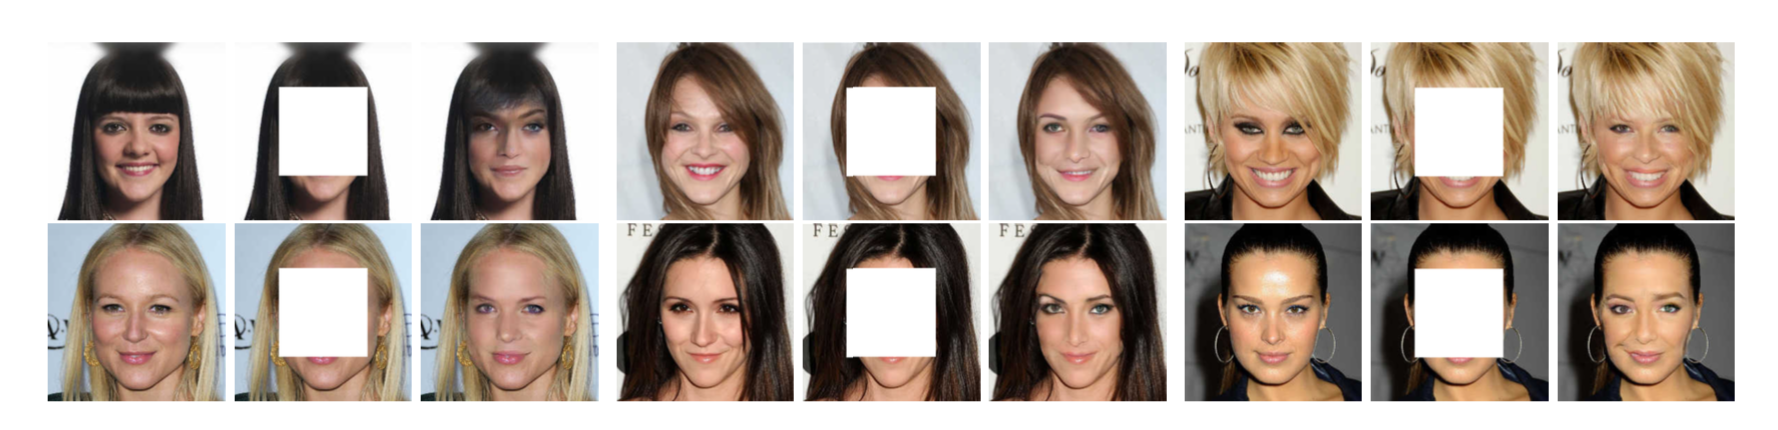

## ImageNet:
Results on the ImageNet-Dataset with attention map:
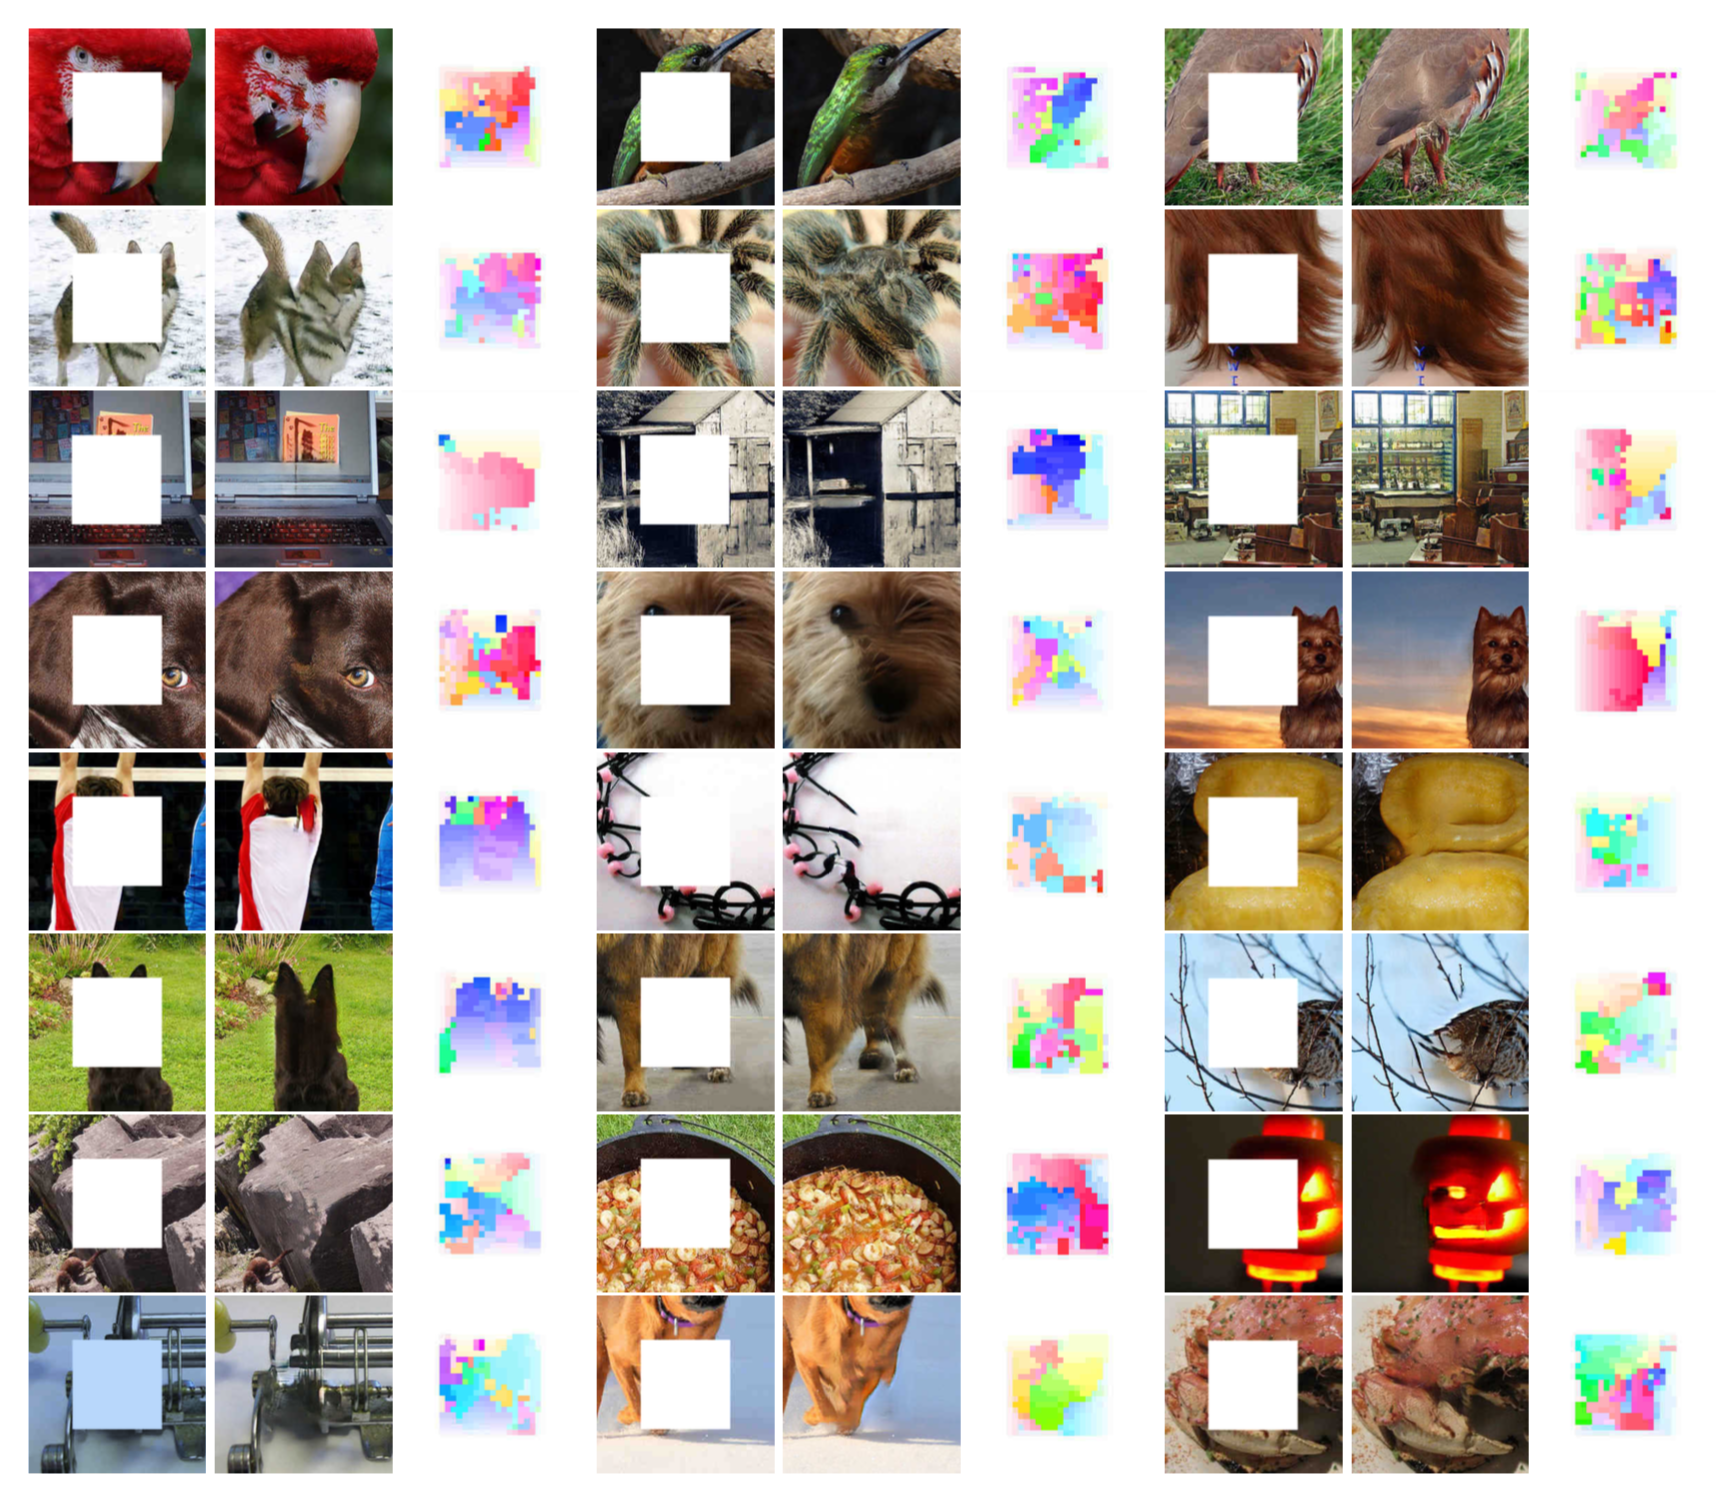